In [792]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
import datetime
import scipy as sp
import utm

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

## Importing dataset:

In [793]:
MMSI636092331 = pd.read_csv(r"MMSI636092331.csv")
MMSI636092331

,mmsi,lat,long,sog,rot,cog,datetimestamp
0,636092331,-4.767917,48.766190,12.2,15,61.0,2016-03-03 10:58:24
1,636092331,-4.835128,48.742413,13.1,-27,68.5,2016-03-03 10:43:54
2,636092331,-4.835327,48.742360,12.8,-29,68.3,2016-03-03 10:43:53
3,636092331,-4.835595,48.742290,12.4,-37,67.1,2016-03-03 10:43:48
4,636092331,-4.836520,48.742012,12.8,-19,61.4,2016-03-03 10:43:38
...,...,...,...,...,...,...,...
6245,636092331,-5.127655,48.122654,13.3,28,76.4,2016-03-02 04:53:52
6246,636092331,-5.128298,48.122547,13.1,36,74.6,2016-03-02 04:53:46
6247,636092331,-5.128785,48.122480,13.6,-14,71.4,2016-03-02 04:53:40
6248,636092331,-5.129277,48.122353,13.8,34,72.9,2016-03-02 04:53:34


# Converting types:

In [794]:
def convert_cog(data_in):
    return data_in*np.pi/180 #convert to radians

In [795]:
def convert_rot(data_in):
    return (data_in/60)*np.pi/180 #rad per second
    

In [796]:
def convert_sog(data_in):
    return data_in*0.5144444444 #meter per second

In [797]:
def convert_XY(data_in):
    #constants:
    a = 6378137.0
    b = 6356752.3
    
    lat = data_in['lat']
    long = data_in['long']
    def calc_N(a,b,lat):
        e = (a**2 -b**2)/a**2
        return a*(np.sqrt(1-e*np.sin(lat)**2))
    h = 0
    N = calc_N(a,b,lat)
    X = (N+h)*np.cos(lat)*np.cos(long)
    Y = (N+h)*np.cos(lat)*np.sin(long)
    
    

In [798]:
def convert_dataset(data_in):
    #Converting time date:
    df_sorted = copy.deepcopy(data_in.sort_values(by = 'datetimestamp', ascending = True ))
    first_obs_date = df_sorted.iloc[0,6]

    
    df_sorted['datetimestamp'] = ((pd.to_datetime(df_sorted['datetimestamp']) - pd.to_datetime(first_obs_date)).dt.total_seconds())

    #Conversion of Course over ground
    df_sorted['cog'] = convert_cog(df_sorted['cog'])
    
    #Convert Speed over ground to mps
    df_sorted['sog'] = convert_sog(df_sorted['sog'])
    
    #Convert rate of turn 
    df_sorted['rot'] = convert_rot(df_sorted['rot'])
    
    #Making the order same as testset
    
    df_sorted = df_sorted[['datetimestamp', 'lat', 'long', 'cog', 'sog','rot']]
    
    #Adding delta time and updating the order again & CONVERT X Y
    
    X = []
    X.append(utm.from_latlon(df_sorted['lat'][0], df_sorted['long'][0])[0])
    Y = []
    Y.append(utm.from_latlon(df_sorted['lat'][0], df_sorted['long'][0])[1])

    delta_time = []
    for i in np.arange(1, len(df_sorted['datetimestamp']),1):
        delta_time.append(int(df_sorted['datetimestamp'][i-1])-int(df_sorted['datetimestamp'][i]))
        ans = utm.from_latlon(df_sorted['lat'].values[i], df_sorted['long'].values[i])
        X.append(copy.deepcopy(ans[0]))
        Y.append(copy.deepcopy(ans[1]))
    
    
    delta_time.append(0)
    
    reversed_list = np.array(delta_time[::-1])
    df_sorted.insert(1,'deltatime',reversed_list) #adding the delta time row

    df_sorted['lat'] = Y
    df_sorted['long'] = X
   
    return df_sorted
    
    

In [799]:
def discrete_subsample_data(data_in, eachObs = 10):
    sub_script = np.arange(0,len(data_in),eachObs)
    return data_in.iloc[sub_script,:]
    
    

In [800]:
def trim_data(df_in, lower, upper, interval = 1):
    df_out = df_in.iloc[np.arange(int(len(df_in)*lower),int(len(df_in)*upper),interval),:]
    return df_out

# Testing Kalman

In [802]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def get_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    return A

def predict_state(A, X_prev, a_x, a_y, deltaTIME):
        
    Bu_k = np.array([[a_x*deltaTIME*deltaTIME/2],
                     [a_y*deltaTIME*deltaTIME/2],
                     [a_x*deltaTIME],
                     [a_y*deltaTIME]])
    
    pred_state = A.dot(X_prev) + Bu_k
    return pred_state

def pred_err_cov(A, Pk, Q):
    return A.dot(Pk).dot(np.transpose(A)) + Q

def Kalman_gain(P_k, H, R):
    above = P_k.dot(np.transpose(H))
    bottom = np.linalg.inv(H.dot(P_k).dot(np.transpose(H)) + R)
    return above.dot(bottom)

def adjust_pred_state(pred_state, Kk,z_k,H):
    #Where z_k == the real observed value to adjust for the errors made
    return pred_state + Kk.dot(z_k - H.dot(pred_state))

def update_err_cov(I,Kk,H,P_k):
    return (I - Kk.dot(H)).dot(P_k)    

def calc_a_xy(arr_in, arr_prev):
    
    sog_now = np.around(arr_in[5],8)
    sog_prev = np.around(arr_prev[5],8)
    
    cog_now = np.around(arr_in[4],8)
    cog_prev = np.around(arr_prev[4],8)
    
    rot_now = np.around(arr_in[6],6)
    
    delta_time = arr_in[1]
    
    a_x = (sog_now*np.cos(cog_now + rot_now*delta_time) - sog_prev*np.cos(cog_prev))/delta_time
    
    a_y = (sog_now*np.sin(cog_now + rot_now*delta_time) - sog_prev*np.sin(cog_prev))/delta_time 
    
    return a_x, a_y
    

In [803]:
def convert_state(arr_in):
    sog = arr_in[5]
    cog = arr_in[4]
    
    x = arr_in[2]
    y = arr_in[3]
    Vx = sog*np.cos(deg_to_rad(cog))
    Vy = sog*np.sin(deg_to_rad(cog))
    
    return_arr = np.array([[x],[y],[Vx],[Vy]])
    
    return return_arr

In [804]:
def extract_long_lat_covariance(mat_in):
    Var1 = mat_in[0,0]
    Var2 = mat_in[1,1]
    Cov12 = mat_in[0,1]
    
    result = np.array([[Var1,Cov12],[Cov12,Var2]])
    return result

In [805]:
var_lat = np.var(pd_final['lat'])
var_long = np.var(pd_final['long'])
covar = np.cov(pd_final['lat'],pd_final['long'])[0][1]
print('varlat',var_lat)
print('varlong',var_long)
print('covar:', covar)

varlat 144852527.2923734
varlong 5057.387167570333
covar: -237917.096445377


### Reducing, converting the data and subsample the trac

    datetimestamp  deltatime           lat           long       cog       sog  \
30            0.0          0  9.474131e+06  180815.871530  1.185079  7.099333   
29           47.0         31  9.432181e+06  180898.363459  1.305506  7.202222   
28           71.0         23  9.432422e+06  180949.325222  1.296780  6.739222   
27           78.0         24  9.432483e+06  180961.367941  1.300270  6.842111   
26           83.0         30  9.432542e+06  180966.099682  1.357866  6.945000   

         rot  
30  0.006400  
29  0.005527  
28  0.007272  
27  0.007272  
26  0.007854  


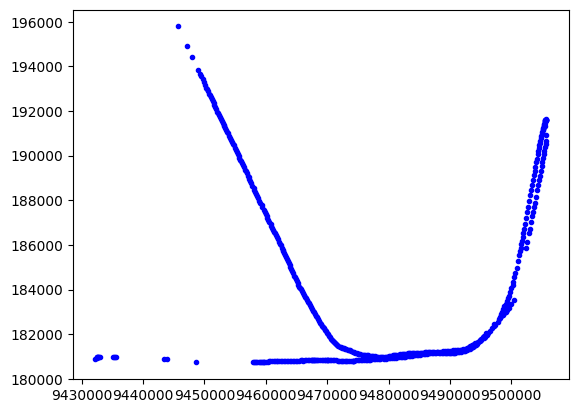

In [806]:
kkkkk = trim_data(MMSI636092331,0.2,0.55,4)
pd_final=  copy.deepcopy(convert_dataset(kkkkk.reset_index(drop = True))) #convert the given data as if it was new
print(pd_final.head())
#plot - to show extracted trajectory
plt.plot(pd_final['lat'],pd_final['long'], 'b.')
plt.show()

## Setting matrices:

### $P_k$ :

In [807]:
P_k = np.array([[159577732],[50],[0.3],[0.3]]).dot(np.transpose(np.array([[50],[50],[0.3],[0.3]])))

### Sensitivity Matrices

In [808]:
R = np.diag(np.array([5000,5000,0.003,0.003]))

Q = np.array([[50000],[5000],[0.01],[0.01]]).dot(np.transpose(np.array([[50000],[5000],[0.01],[0.01]])))


### Other matrices:

In [809]:
H = np.identity(4)
I = np.identity(4)

In [827]:
P_k = np.array([[np.sqrt(var_lat)],
                [np.sqrt(var_long)],
                [np.sqrt(a_x_var)],
                [np.sqrt(a_y_var)]]
              ).dot(np.transpose(
    np.array([[np.sqrt(var_lat)],
              [np.sqrt(var_long)],
                [np.sqrt(a_x_var)],
                [np.sqrt(a_y_var)]]
            )))

Q = copy.deepcopy(P_k)

R = np.diag(np.array([var_lat, var_long,a_x_var, a_y_var]))
ax_arr = []
ay_arr= []
Pk_save_states = []
def myKalman(pd_final, R,Q,P_k):
    # Kalman Initial state
    X_state = np.array([[0],[0],[0],[0]])
    global ax_arr, ay_arr, df_final,Pk_save_states
    
    
    
    # Lists to append data and values to, saving ttansitions:
    ax_arr = []
    ay_arr = []
    X_save_states = []
    Pk_save_states = []
    Pk_save_states.append(copy.deepcopy(P_k))

    data_counter = 1 # counter for the original data set obsevations

    max_time = int(max(pd_final.iloc[:,0]))
    min_time = int(min(pd_final.iloc[:,0]))

    data_counter_stop = max_time-min_time

    for i in np.arange(0,max_time,1):

        '''If we observe the value we observe this'''
        if(i == 0 or (int(pd_final.iloc[data_counter,0]) == i and data_counter < data_counter_stop)):
            zk_prev = pd_final.iloc[data_counter-1,:].values #previous observation
            z_k = pd_final.iloc[data_counter,:].values # convert to numpy array -observed value

            delta_TIME = copy.deepcopy(z_k[1]) #difference in time
            A = get_mat_A(delta_TIME)

            #Acceleration
            ax, ay = calc_a_xy(z_k,zk_prev) 
            ax_arr.append(ax)
            ay_arr.append(ay)

            z_k = copy.deepcopy(convert_state(z_k)) #convert state
            X_state = copy.deepcopy(convert_state(zk_prev))

            #Kalman Predict--------------------------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A, P_k, Q))

            #Kalman Measuremenet update--------------------------------------------------------------------------------
            Kalman_k = copy.deepcopy(Kalman_gain(P_k, H, R))
            X_state = copy.deepcopy(adjust_pred_state(X_state, Kalman_k, z_k, H))
            P_k = copy.deepcopy(update_err_cov(I, Kalman_k, H, P_k))


            #increment counter
            data_counter += 1

            #Saving states
            X_save_states.append(copy.deepcopy(X_state))
            Pk_save_states.append(copy.deepcopy(P_k))

        else:
            '''This code will be excecuted when we have no observation'''

            ay = 0
            ax = 0
            A = get_mat_A(1)
            #Kalman Predict --------------------------------------------------------------------------
            X_state = copy.deepcopy(predict_state(A, X_state, ax, ay, 1))
            P_k =  copy.deepcopy(pred_err_cov(A,P_k,Q))

            #Saving states
            Pk_save_states.append(copy.deepcopy(P_k))
            X_save_states.append(copy.deepcopy(X_state))




    # Saving the coordinates:
    X_coord = []
    Y_coord = []
    Pk_coord  = []

    for i in range(0,len(X_save_states)):
        if i > 1 and  i % 1 == 0:
            X_coord.append(X_save_states[i][0][0])
            #print(X_save_states[i][0][0])
            Y_coord.append(X_save_states[i][1][0])
            Pk_coord.append(extract_long_lat_covariance(Pk_save_states[i]))

    #Extracting the original data:
    X_orig = copy.deepcopy(pd_final.iloc[:,2])
    Y_orig = copy.deepcopy(pd_final.iloc[:,3])

    # Plotting the original vs predicted
    
    plt.plot(X_orig,Y_orig,"rx")    
    plt.plot(X_coord,Y_coord, "b.")
    
    plt.show()

    print("sum pred:", len(X_coord))
    print("sum orig:", len(X_orig))

    #Plotting both banned by the original's  min and max
    plt.plot(X_coord,Y_coord, "b.")
    plt.plot(X_orig.values[np.arange(0, len(X_orig),5)],Y_orig.values[np.arange(0, len(X_orig),5)],"rx")
    plt.title("Kalman prediction and original data")
    plt.xlabel("X - coordinate")
    plt.ylabel("Y - coordinate")
    legend_data = np.array(["Prediction","Original"])
    plt.legend(legend_data, loc = "best")
    plt.xlim(min(X_orig)-500, max(X_orig)+500)
    plt.ylim(min(Y_orig)-500,max(Y_orig)+500)
    plt.show()




## Data set

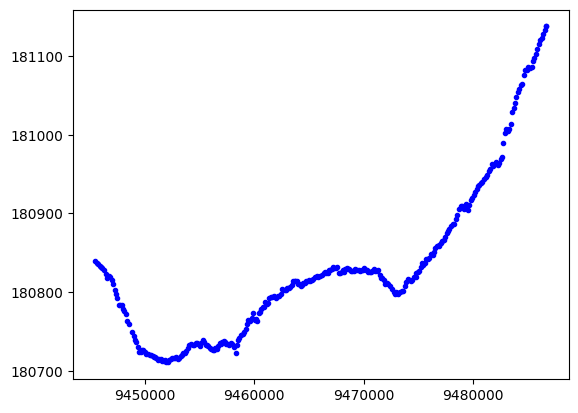

In [828]:

kkkkk = trim_data(MMSI636092331,0.48,0.58,2)
pd_final=  copy.deepcopy(convert_dataset(kkkkk.reset_index(drop = True))) #convert the given data as if it was new

#plot - to show extracted trajectory
plt.plot(pd_final['lat'],pd_final['long'], 'b.')
plt.show()

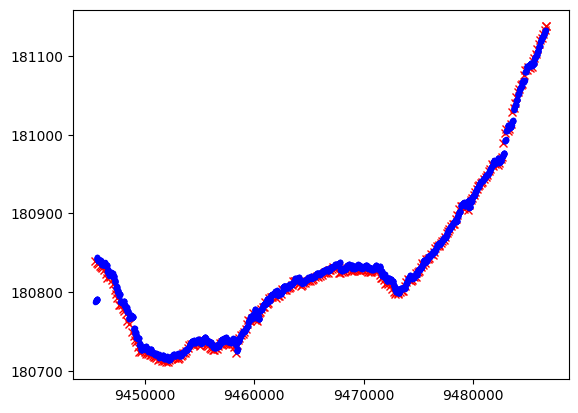

sum pred: 3844
sum orig: 312


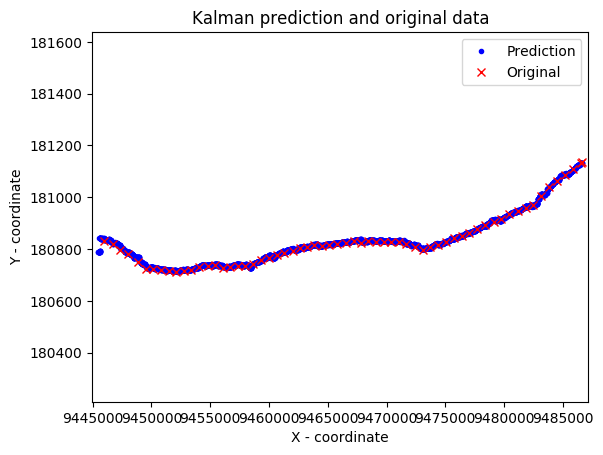

In [829]:
a_x_var = 0.0000288638283
a_y_var = 0.0000289287
var_lat = np.var(pd_final['lat'])
var_long = np.var(pd_final['long'])

P_k = np.array([[np.sqrt(var_lat)],
                [np.sqrt(var_long)],
                [np.sqrt(a_x_var)],
                [np.sqrt(a_y_var)]]
              ).dot(np.transpose(
    np.array([[np.sqrt(var_lat)],
              [np.sqrt(var_long)],
                [np.sqrt(a_x_var)],
                [np.sqrt(a_y_var)]]
            )))

# P_k = np.array([[1000000],
#                 [100000],
#                 [0.03],a
#                 [0.03]]
#               ).dot(np.transpose(
#     np.array([[10000],
#               [10000],
#                 [0.03],
#                 [0.03]]
#             )))

Q = copy.deepcopy(P_k)

R = np.diag(np.array([100,100,0.0009,0.000001]))


myKalman(pd_final, R,Q,P_k)

310


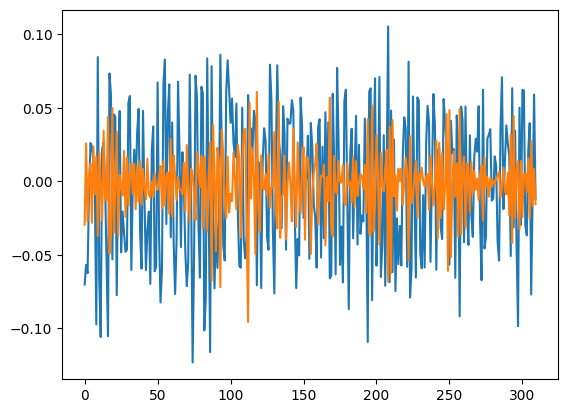

In [830]:
plt.plot(np.arange(0,len(ax_arr)),ax_arr)
plt.plot(np.arange(0,len(ax_arr)),ay_arr)
print(len(ax_arr))
plt.show()

In [831]:
print(np.cov(ax_arr,ay_arr))
var_lat = np.var(pd_final['lat'])
var_long = np.var(pd_final['long'])
print(var_lat)
print(var_long)

[[ 0.00254033 -0.00054585]
 [-0.00054585  0.00057203]]
141401106.49655047
10311.374065178368


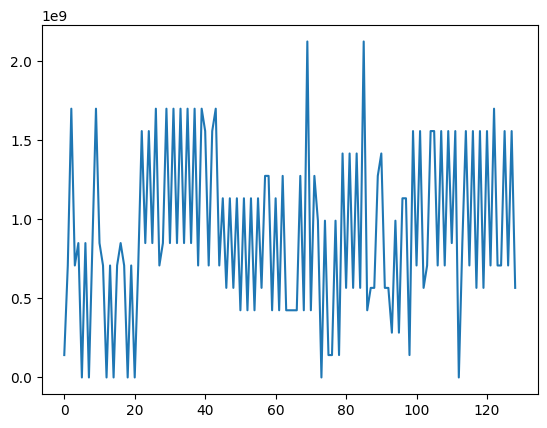

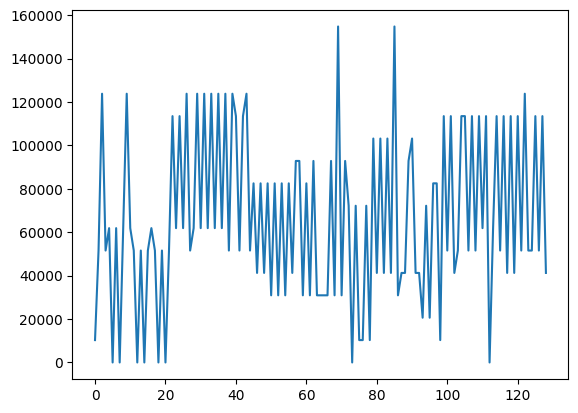

In [849]:
Pk_var_X = []
Pk_var_Y = []

my_range = np.arange(0, len(Pk_save_states),1)

mytest= 0
for iter_var in my_range:    
    if(iter_var % 30 == 0):
        mytest += 1
        Pk_var_X.append(Pk_save_states[iter_var][0][0])
        Pk_var_Y.append(Pk_save_states[iter_var][1][1])
    

my_range = np.arange(0, mytest,1)  
plt.plot(my_range,Pk_var_X)
plt.show()
plt.plot(my_range,Pk_var_Y)
plt.show()

    

In [786]:
var_lat

89978811.31593537

In [839]:
Pk_save_states[0][1][1]

10311.37406517837

In [837]:
Pk_save_states[0]

array([[1.41401106e+08, 1.20749315e+06, 6.38856577e+01, 6.39574092e+01],
       [1.20749315e+06, 1.03113741e+04, 5.45550851e-01, 5.46163572e-01],
       [6.38856577e+01, 5.45550851e-01, 2.88638283e-05, 2.88962459e-05],
       [6.39574092e+01, 5.46163572e-01, 2.88962459e-05, 2.89287000e-05]])